import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [117]:
import tensorflow as tf
import os
import cv2
from PIL import Image
import numpy as np

In [118]:
image_directory = 'A:/signatures/train/'
SIZE = 50
image_size = (SIZE,SIZE)
dataset = []
label = []

A:/signatures/train/0 ---> prajwol


A:/signatures/train/4----> suprim



same for test

Prepare data for training

In [119]:
good_images = os.listdir(image_directory + '0/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [120]:
dirs = os.listdir(image_directory)

In [121]:
good_images = os.listdir(image_directory + '4/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '4/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [122]:
dataset = np.array(dataset)
label = np.array(label)
dataset.shape, label.shape

((194, 50, 50), (194,))

Prepare Data For Testing

In [123]:
test_dataset = []
test_label= []
image_directory = 'A:/signatures/test/'

In [124]:
good_images = os.listdir(image_directory + '0/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_dataset.append(np.array(image))
        test_label.append(0)

In [125]:
good_images = os.listdir(image_directory + '4/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '4/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_dataset.append(np.array(image))
        test_label.append(1)

In [126]:
test_dataset = np.array(test_dataset)
test_label = np.array(test_label)
test_dataset.shape, test_label.shape

((10, 50, 50), (10,))

y_train

In [127]:
DEPTH = 50 

In [128]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((image_size), name='img_A_inp')
img_B_inp = Input((image_size), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((SIZE,SIZE, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  BatchNormalization(),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*4),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_A_inp (InputLayer)         [(None, 50, 50)]     0           []                               
                                                                                                  
 img_B_inp (InputLayer)         [(None, 50, 50)]     0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 64)           979520      ['img_A_inp[0][0]',              
                                                                  'img_B_inp[0][0]']              
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128)          0           ['sequential_9[0][0]',     

In [129]:
X_train = dataset.copy()
y_train = label.copy()
X_test = test_dataset.copy()
y_test = test_label.copy()

random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

In [130]:
len(X_train)**2

37636

In [131]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]
  
  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)
  
  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [132]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train, y_train)
X_train_pairs.shape, y_train_pairs.shape

((37636, 2, 50, 50), (37636,))

random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

X_test, y_test = X_test[random_indices], y_test[random_indices]

X_test.shape, y_test.shape

In [133]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test, y_test)

X_test_pairs.shape, y_test_pairs.shape

((100, 2, 50, 50), (100,))

In [134]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [135]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [156]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_split = 0.2,
          epochs=5,
          batch_size=32,
          callbacks=[es],
         )

Epoch 1/5
941/941 [==============================] - 100s 106ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 2.6178e-05 - val_accuracy: 1.0000
Epoch 2/5
941/941 [==============================] - 97s 104ms/step - loss: 2.1290e-05 - accuracy: 1.0000 - val_loss: 3.3621e-05 - val_accuracy: 1.0000
Epoch 3/5
941/941 [==============================] - 98s 104ms/step - loss: 3.4339e-06 - accuracy: 1.0000 - val_loss: 3.6293e-06 - val_accuracy: 1.0000
Epoch 4/5
941/941 [==============================] - 96s 102ms/step - loss: 2.4045e-06 - accuracy: 1.0000 - val_loss: 7.3796e-07 - val_accuracy: 1.0000
Epoch 5/5
941/941 [==============================] - 98s 104ms/step - loss: 7.0819e-07 - accuracy: 1.0000 - val_loss: 3.0267e-07 - val_accuracy: 1.0000


In [157]:
siamese = model.save('alpha_50x50_5epochs_extra layer.h5')

In [160]:
x = tf.keras.models.load_model('alpha_50x50_5epochs_extra layer.h5')

In [161]:
image_directory = 'A:/signatures/test/'
SIZE = 50
test__dataset = [] 
test__label = [] # has double underscore

good_images = os.listdir(image_directory + '0/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(0)
        
good_images = os.listdir(image_directory + 'forged/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'forged/' + image_name,0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(1)
        

In [162]:
test__dataset = np.array(test__dataset)

In [176]:
img_A, img_B = test__dataset[1],test__dataset[6]
label_A, label_B = test__label[1], test__label[8]
label_A, label_B

(0, 1)

img_A, img_B = X_test[6], X_test[7]
label_A, label_B = y_test[6], y_test[7]
label_A, label_B

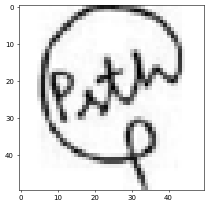

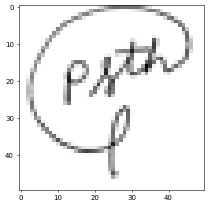

In [177]:
import matplotlib.pyplot as plt

plt.figure(dpi=50)
plt.imshow(img_A, cmap = 'gray')

plt.figure(dpi=50)
plt.imshow(img_B, cmap = 'gray')

In [171]:
prediction = model.predict([img_A.reshape((1, 50,50)), 
               img_B.reshape((1, 50,50))])
print(f"similarity = {prediction}")
print('Not Matched' if prediction[0]*100 < 80 else ' Matched')

1/1 [==============================] - 0s 17ms/step
similarity = [[1.7437495e-08]]
Not Matched


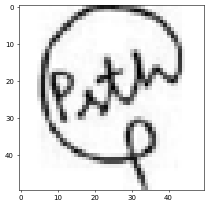

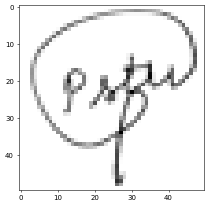

In [172]:
image_directory = 'A:/signatures/test/'
SIZE = 50
test__dataset = [] 
test__label = [] # has double underscore

good_images = os.listdir(image_directory + '0/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(0)
        
good_images = os.listdir(image_directory + 'forged/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'forged/' + image_name,0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(1)

test__dataset = np.array(test__dataset)
img_A, img_B = test__dataset[1],test__dataset[5]
label_A, label_B = test__label[1], test__label[5]
label_A, label_B

import matplotlib.pyplot as plt

plt.figure(dpi=50)
plt.imshow(img_A, cmap = 'gray')

plt.figure(dpi=50)
plt.imshow(img_B, cmap = 'gray')

In [173]:
prediction = model.predict([img_A.reshape((1, 50,50)), 
               img_B.reshape((1, 50,50))])
print(f"similarity = {prediction}")
print('Not Matched' if prediction[0]*100 < 80 else ' Matched')

1/1 [==============================] - 0s 20ms/step
similarity = [[9.239776e-09]]
Not Matched


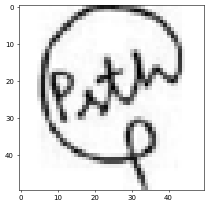

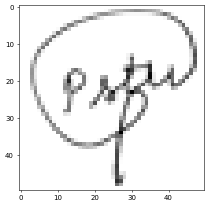

In [193]:
image_directory = 'A:/signatures/test/'
SIZE = 50
test__dataset = [] 
test__label = [] # has double underscore

good_images = os.listdir(image_directory + '0/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + '0/' + image_name,cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(0)
        
good_images = os.listdir(image_directory + 'forged/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'forged/' + image_name,0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test__dataset.append(np.array(image))
        test__label.append(1)

test__dataset = np.array(test__dataset)
img_A, img_B = test__dataset[1],test__dataset[5]
label_A, label_B = test__label[1], test__label[5]
label_A, label_B

import matplotlib.pyplot as plt

plt.figure(dpi=50)
plt.imshow(img_A, cmap = 'gray')

plt.figure(dpi=50)
plt.imshow(img_B, cmap = 'gray')

In [194]:
prediction = model.predict([img_A.reshape((1, 50,50)), 
               img_B.reshape((1, 50,50))])
print(f"similarity = {prediction}")
print('Not Matched' if prediction[0]*100 < 80 else ' Matched')

1/1 [==============================] - 0s 18ms/step
similarity = [[9.239776e-09]]
Not Matched
